In [3]:
import os
import requests
import pandas as pd
from dotenv import load_dotenv

# Ladda miljövariabler från .env
load_dotenv()

# Hämta klientuppgifter
CLIENT_ID = os.getenv("STRAVA_CLIENT_ID")
CLIENT_SECRET = os.getenv("STRAVA_CLIENT_SECRET")
REDIRECT_URI = os.getenv("STRAVA_REDIRECT_URI")

print("✅ Miljövariabler laddade.")

✅ Miljövariabler laddade.


In [4]:
# Skapa OAuth URL
oauth_url = (
    f"https://www.strava.com/oauth/authorize?"
    f"client_id={CLIENT_ID}&"
    f"response_type=code&"
    f"redirect_uri={REDIRECT_URI}&"
    f"approval_prompt=auto&"
    f"scope=activity:read_all"
)

print("👉 Öppna denna länk i din webbläsare och godkänn åtkomst:")
print(oauth_url)

👉 Öppna denna länk i din webbläsare och godkänn åtkomst:
https://www.strava.com/oauth/authorize?client_id=179461&response_type=code&redirect_uri=http://localhost:8888/callback&approval_prompt=auto&scope=activity:read_all


In [7]:
# Klistra in koden du fick från omdirigeringen här
AUTHORIZATION_CODE = "7132ef90d982269d082ee6922e5b8fa885cae521"
# Byt code mot tokens
token_url = "https://www.strava.com/oauth/token"
payload = {
    "client_id": CLIENT_ID,
    "client_secret": CLIENT_SECRET,
    "code": AUTHORIZATION_CODE,
    "grant_type": "authorization_code"
}

response = requests.post(token_url, data=payload)

if response.status_code == 200:
    token_data = response.json()
    ACCESS_TOKEN = token_data["access_token"]
    REFRESH_TOKEN = token_data["refresh_token"]

    # Spara tokens i .env
    with open(".env", "a") as f:
        f.write(f"\nSTRAVA_ACCESS_TOKEN={ACCESS_TOKEN}")
        f.write(f"\nSTRAVA_REFRESH_TOKEN={REFRESH_TOKEN}")

    print("✅ Tokens hämtade och sparade i .env")
else:
    print("❌ Fel vid tokenhämtning:", response.text)

✅ Tokens hämtade och sparade i .env


In [8]:
def refresh_access_token():
    global ACCESS_TOKEN, REFRESH_TOKEN

    url = "https://www.strava.com/oauth/token"
    payload = {
        "client_id": CLIENT_ID,
        "client_secret": CLIENT_SECRET,
        "grant_type": "refresh_token",
        "refresh_token": REFRESH_TOKEN
    }

    response = requests.post(url, data=payload)

    if response.status_code == 200:
        data = response.json()
        ACCESS_TOKEN = data["access_token"]
        REFRESH_TOKEN = data["refresh_token"]

        # Uppdatera .env-filen
        with open(".env", "r") as f:
            lines = f.readlines()
        with open(".env", "w") as f:
            for line in lines:
                if line.startswith("STRAVA_ACCESS_TOKEN="):
                    f.write(f"STRAVA_ACCESS_TOKEN={ACCESS_TOKEN}\n")
                elif line.startswith("STRAVA_REFRESH_TOKEN="):
                    f.write(f"STRAVA_REFRESH_TOKEN={REFRESH_TOKEN}\n")
                else:
                    f.write(line)

        print("✅ Token förnyad och .env uppdaterad")
    else:
        print("❌ Fel vid tokenförnyelse:", response.text)

In [9]:
def get_strava_activities():
    url = "https://www.strava.com/api/v3/athlete/activities"
    headers = {"Authorization": f"Bearer {ACCESS_TOKEN}"}
    response = requests.get(url, headers=headers)

    if response.status_code == 200:
        return response.json()
    else:
        print("❌ Fel vid hämtning av aktiviteter:", response.text)
        return []

# Förnya token innan du hämtar data
refresh_access_token()

# Hämta data
activities = get_strava_activities()

✅ Token förnyad och .env uppdaterad


,name,type,distance_km,moving_time_h,start_date_local
0,Lunch Run,Run,0.0000,0.001111,2025-12-16T12:23:37Z
1,Morning Run,Run,5.9999,0.546111,2025-12-15T07:00:08Z
2,Afternoon Run,Run,5.0720,0.494167,2025-12-11T15:39:22Z
3,Morning Run,Run,5.0048,0.456944,2025-12-08T06:13:36Z
4,Morning Run,Run,4.0076,0.355833,2025-12-07T09:29:17Z


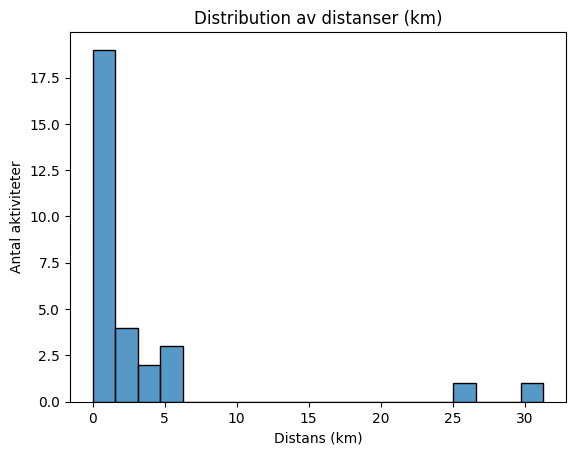

In [10]:
# Konvertera till DataFrame
df = pd.DataFrame(activities)

# Enkel bearbetning
df['distance_km'] = df['distance'] / 1000
df['moving_time_h'] = df['moving_time'] / 3600

# Visa första raderna
display(df[['name', 'type', 'distance_km', 'moving_time_h', 'start_date_local']].head())

# Plotta distansfördelning
import matplotlib.pyplot as plt
import seaborn as sns

sns.histplot(df['distance_km'], bins=20)
plt.title("Distribution av distanser (km)")
plt.xlabel("Distans (km)")
plt.ylabel("Antal aktiviteter")
plt.show()

In [14]:
from stravalib.client import Client
import datetime
from dotenv import load_dotenv
import os
import pytz  # för tidszonshantering

load_dotenv()
client = Client()

access_token = os.getenv('STRAVA_ACCESS_TOKEN')
if not access_token:
    raise ValueError("STRAVA_ACCESS_TOKEN saknas i miljövariablerna")

client.access_token = access_token

# Använd UTC timezone för after och before
utc = pytz.UTC
after = utc.localize(datetime.datetime(2025, 12, 1))
before = utc.localize(datetime.datetime.now())

# Hämtar aktiviteter med paginering
activities = client.get_activities(after=after, before=before)

count = 0
for activity in activities:
    print(activity.name, activity.start_date, activity.distance, activity.average_heartrate, activity.max_heartrate)
    count += 1

if count == 0:
    print("Inga aktiviteter hittades i det angivna datumintervallet.")

Lunch Run 2025-12-16 11:23:37+00:00 0.0 75.3 76
Morning Run 2025-12-15 06:00:08+00:00 5999.9 150.6 172
Afternoon Run 2025-12-11 14:39:22+00:00 5072.0 147.2 162
Morning Run 2025-12-08 05:13:36+00:00 5004.8 154.2 165
Morning Run 2025-12-07 08:29:17+00:00 4007.6 150.2 167
Afternoon Ride 2025-12-04 16:17:35+00:00 0.0 155.7 182
Morning Run 2025-12-01 05:46:07+00:00 4014.1 148.7 167
